# Programming Assingnment2 - ResNet, LSTM Implementation
안녕하세요 **AIKU 학회원 여러분!**, 두 번째 과제는 지난 주에 배웠던 CNN variant 중 하나인 ResNet, RNN의 발전된 형태인 LSTM을 구현하는 것입니다!

모델을 2개나 재구현해야한다니.. 상당히 과제 덩치가 커보이실 수도 있지만, 수업 내용과 실습 내용을 쭉 따라오셨으면 쉽게 풀 수 있는 난이도로 제작하였으니 걱정하지 않으셔도 됩니다!

이번 과제에서는 ResNet으로는 CIFAR-10 데이터셋을 이용한 이미지 classification, LSTM으로는 감정분석 task를 수행할 예정입니다. 네이버의 영화 리뷰 데이터를 모델의 입력으로 받아, 이 리뷰가 긍정적인지 부정적인지를 분류하는 task를 수행하는 LSTM 모델을 구현해 볼 예정입니다.


또한, 모델만 재구현 하는 것이 아니라, DataLoader 구현 및 DataLoader를 위한 Dataset으로의 전처리 과정까지 함께 다룰 예정이니다.

그럼 이제 시작해 볼까요?



# Part 1. ResNet


## 1-1. 라이브러리 설치 및 불러오기
ResNet 구현에 필요한 라이브러리를 설치 및 불러오는 과정입니다.

In [1]:
!pip install wget
!pip install torch torchaudio torchvision
!pip install numpy

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=ff9fa9da1ef887890c7f04d46ffba53668f6daf8df30b09536beec0892c03676
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (1

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pickle
import tarfile
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

## 1-2. device 지정
런타임에 활용할 device에 cpu 또는 cuda(GPU)를 할당할 것인지 지정하는 단계입니다.
단, 구현 중에는 **CPU**로 사용을 권장드립니다!
GPU가 가장 많이 필요한 단계는 학습하는 과정인데 구현하는 시간동안 colab의 GPU를 다 써버리면 막상 학습할 때 필요한 GPU 자원을 쓸 수 없게 됩니다. 따라서 코드를 모두 구현하고 train 코드가 잘 돌아가는지 확인한 뒤에 colab 상단 런타임 메뉴에서 런타임 유형을 GPU로 바꾼 뒤에 실행하면 됩니다.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


## 1-3. Google Drive Mount
Colab에서는 컴퓨터에 자원에 접근이 불가능 하므로 Google Drive에 파일을 올려 놓은 후 Google Drive를 mount 에서 로컬 디스크처럼 사용 합니다.

In [4]:
# 지난 과제에서도 했던 과정이기 때문에 똑같이 Google Drive를 Mount해주시면 됩니다.
from google.colab import drive
drive.mount('/content/drive')

# data를 저장할 폴더 입니다. 환경에 맞게 수정 하세요.
data_dir = "/content/drive/MyDrive/D2D/2"

Mounted at /content/drive


## 1-4 CIFAR-10 데이터셋 다운로드
이제 CIFAR-10 데이터셋을 다운로드 할 차례입니다! CIFAR-10은 (비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭) 이렇게 10개 class로 구성이 되어있는 이미지 데이터셋입니다. train set 5만장, test set 1만장으로 구성되어 있으며, 각 이미지의 사이즈는 32*32입니다. 예전에 image recognition 관련 분야에서 항상 활용되었던 데이터셋입니다!

먼저, 데이터셋을 다운 받아봅시다.
아래 코드는 먼저 드라이브에 CIFAR-10 디렉토리를 생성하고, 생성한 디렉토리에 tar.gz 형식의 압축 파일을 다운 받는 역할을 합니다.

**반드시 mount를 하고 진행해 주세요!**

In [ ]:
drive_path = '/content/drive/MyDrive/CIFAR10'
os.makedirs(drive_path, exist_ok=True)

!wget -P {drive_path} https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2024-07-21 04:29:11--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘/content/drive/MyDrive/CIFAR10/cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  30.8MB/s    in 5.9s    

2024-07-21 04:29:17 (27.4 MB/s) - ‘/content/drive/MyDrive/CIFAR10/cifar-10-python.tar.gz’ saved [170498071/170498071]



정상적으로 파일을 다운로드했다면, 이제 파일을 압축 해제해 봅시다.
아래 코드들 실행해 주세요.
train, test 이미지들의 shape도 함께 보실 수 있습니다.

In [ ]:
tar_gz_path = '/content/drive/MyDrive/CIFAR10/cifar-10-python.tar.gz'
extract_path = '/content/drive/MyDrive/CIFAR10/'  # Define where you want to extract the files

os.makedirs(extract_path, exist_ok=True)

!tar -xzvf {tar_gz_path} -C {extract_path}

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar10_dir = '/content/drive/MyDrive/CIFAR10/cifar-10-batches-py/'
cifar10_train_files = [os.path.join(cifar10_dir, f"data_batch_{i}") for i in range(1, 6)]

def load_all_cifar10_batches(dirs):
    data_list = []
    labels_list = []
    for dir in dirs:
        batch = load_cifar10_batch(dir)
        data_list.append(batch[b'data'])
        labels_list.append(batch[b'labels'])

    data = np.concatenate(data_list)
    labels = np.concatenate(labels_list)

    return data, labels

# train, test 이미지 및 라벨들 불러오기
train_img, train_labels = load_all_cifar10_batches(cifar10_train_files)
test_img, test_labels = load_all_cifar10_batches(['/content/drive/MyDrive/CIFAR10/cifar-10-batches-py/test_batch'])

# data reshaping
train_img = train_img.reshape((len(train_img), 3, 32, 32)).transpose(0, 2, 3, 1)
test_img = test_img.reshape((len(test_img), 3, 32, 32)).transpose(0, 2, 3, 1)

print(f"Train_Data shape: {train_img.shape}")
print(f"Train_Labels shape: {len(train_labels)}")

print(f"Test_Data shape: {test_img.shape}")
print(f"Test_Labels shape: {len(test_labels)}")

Train_Data shape: (50000, 32, 32, 3)
Train_Labels shape: 50000
Test_Data shape: (10000, 32, 32, 3)
Test_Labels shape: 10000


위의 코드가 정상적으로 모두 실행이 되었다면, CIFAR-10 데이터셋 몇 개를 한번 봐 봅시다! 아래 코드를 실행해주세요.

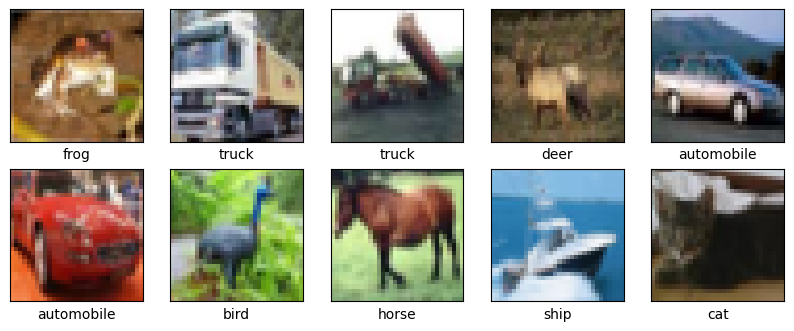

In [ ]:
def show_images(images, labels, class_names, num_images=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i]])
    plt.show()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

show_images(train_img, train_labels, class_names)

## 1-5 Dataset & DataLoader
이제 학습, 테스트 데이터셋도 다 불러왔으니, 전처리를 해야겠죠? 이번 단계에서는 torch.utils.data 아래에 있는 Dataset, DataLoader를 사용해보는 시간을 가질 것입니다. DataLoader는 수업 시간에 배운 batch inference를 가능하게 해주는 기능을 하며, DataLoader는 Dataset 형식을 input으로 받습니다. 그래서 거의 대부분의 전처리를, 데이터셋을 Dataset 형식으로 바꾸어 주는 과정에서 해주시면 됩니다! 모델은 tensor 형식의 입력을 요구하기 때문에, 이 과정에서 텐서로의 형변환도 해주면 더욱 좋겠죠?

그럼 먼저, Dataset으로의 변환부터 진행해 봅시다.

Dataset으로의 변환은 주로 class를 사용해서 이루어집니다. 이 class는 torch.utils.data 아래의 Dataset을 상속받으며, \_\_len\_\_ 메소드와 \_\_getitem\_\_  메소드를 필수적으로 요구합니다. 우리가 직접 사용할 것은 아니고, 나중에 DataLoader가 사용할 것입니다. \_\_len\_\_ 메소드는 이름과 같이 전처리 하고자 하는 데이터셋의 전체 길이(갯수)를 반환하며, \_\_getitem\_\_은 인덱스로 데이터셋의 특정 부분을 반환하는 메소드입니다.


때로는 torchvision의 transforms를 활용하여, input에 변형을 가하거나, 일괄적인 형변환 및 정규화를 진행하기도 합니다. 원본 이미지 input에 변형을 가하는 이유는, 변형으로 인해 이미지의 특정한 feature가 손상되어도, 손상되지 않은 다른 feature를 통해 정확한 예측을 하도록 유도할 수 있어 더 robust한 모델을 만들 수 있기 때문입니다! 쉽게 말해서, 더 어려운 문제인 "기출변형"을 모델에게 학습시키는 것으로 생각하시면 됩니다. 사람마다 어떻게 활용하는지는 다 다를 수 있지만, 이번에는 \_\_getitem\_\_ 내부에서 적용해줍시다!

Dataset, Dataloader를 보다 자세히 알고 싶으시다면, pytorch 공식 튜토리얼을 참고해 주세요:
https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html


### 문제 1. CIFAR10Dataset 구현

In [ ]:
class CIFAR10Dataset(Dataset):
    def __init__(self, image, labels, transform=None):
        self.img = image
        self.labels = labels
        self.transform = transform

    def __len__(self):
      ###############################################
      #####TODO: __len__ 메소드를 구현해 주세요 #####
      ###############################################
        return self.img.shape[0]

    def __getitem__(self, idx):
      ###############################################
      ###TODO: __getitem__ 메소드를 구현해 주세요 ###
        image, label = Image.fromarray(self.img[idx]), self.labels[idx]
      ###############################################

        if self.transform:
          ###############################################
          ###TODO: transforms를 적용해봅시다          ###
          image = self.transform(image)
          ###############################################

        image = torch.tensor(image)
        label = torch.tensor(label)

        return dict(image=image, label=label)

이제 transforms를 선언하고, 이를 통해 train_dataset, test_dataset을 모두 Dataset으로 전처리해줍시다!
transforms_train에 더 많은 transforms를 적용하셔도 좋습니다!


transforms에 대한 더 많은 정보는 해당 링크들을 참조해 주세요:<br>
https://pytorch.org/vision/0.9/transforms.html<br>
https://tutorials.pytorch.kr/beginner/basics/transforms_tutorial.html

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_dataset = CIFAR10Dataset(train_img, train_labels, transform=transform_train)
test_dataset = CIFAR10Dataset(test_img, test_labels, transform=transform_test)

#### 문제 2. transform_train에는 transform_test에 비해 더 많은 transform 기법들이 적용되어 있습니다. 왜 transform_test에는 텐서로의 형변환과 정규화 과정만 포함되어 있을까요? 이 외에 다른 transforms를 transform_test에 적용해도 될까요? 자유롭게 생각을 기술해 주세요

답: 테스트 데이터는 모델을 학습시킨 후 성능을 평가할 때 사용하는 것이기에, 이미지를 변형할 필요가 없다. 가령 자동차 사진을 모델에게 준 후 모델이 그것을 제대로 자동차로 분류하는지 평가하고 싶다면, 해당 자동차 사진을 변형하여 주는 것이 아니라 원본 그대로 주는 것이 합당하다. 그렇기에 transform_test에는 텐서로의 형변환과 정규화 과정만 포함되어 있는 것이다.

거의 마지막입니다. train dataset을 이제 train data과 validation data로 나누어 줍시다. 주로 8 : 2 의 비율로 나누어 줍니다.

In [ ]:
def train_val_split(dataset, ratio):
    train_size = int(ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    return train_dataset, val_dataset

train_dataset, val_dataset = train_val_split(train_dataset, 0.8)

이제 Dataset으로의 전처리가 끝난 만큼, DataLoader를 만들어 줍시다.
아래 코드를 실행하여, train, validation, test dataset에 대한 loader를 선언해 주세요.

train_loader에만 shuffle을 해주는 이유는, 학습 시 매 epoch마다 데이터셋의 학습 순서를 바꾸어 주어, 모델이 학습 데이터셋의 "순서"를 활용하여 예측하는 것을 방지하기 위함입니다. validation, test 시에는 학습을 진행하지 않기에 shuffle을 할 필요가 없습니다.

batch_size는 한 iteration마다 몇 개의 데이터 샘플을 모델에 입력으로 넣을 것인지 선언해 주는 argument입니다 (batch의 크기). batch size가 클 수록 빠르게 학습을 진행할 수 있어, 메모리가 부족하지 않는 이상 DataLoader를 활용하는 것이 효율적입니다.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## 1-6 ResNet 구현!
이제 모든 준비를 마쳤으니, ResNet을 구현해 봅시다!
ResNet은 ResNet-18, 50 등등 모델 크기에 따라 여러 종류가 있지만, 여기에서는 ResNet-18을 재구현하도록 하겠습니다.

ResNet은 VGG와 비슷하게, residual connection을 가지고 있는 여러 개의 residual block들로 구성이 되어 있습니다. 그 구조는 아래 그림과 같습니다:
<br>
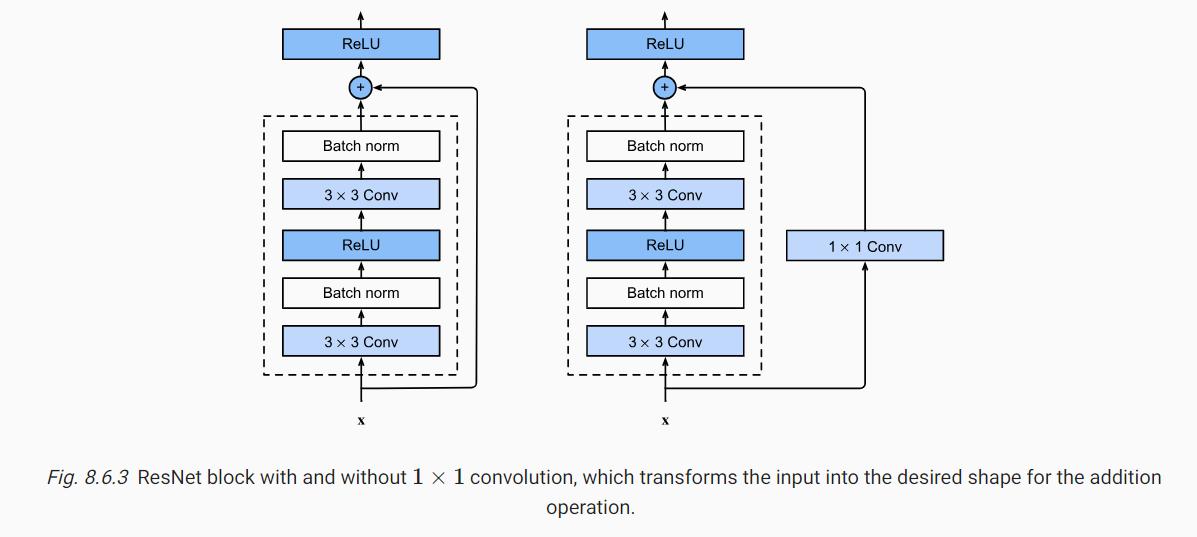

residual block의 input shape과 output shape이 같은 경우에는 왼쪽의 residual block을, 다른 경우에는 오른쪽의 $1 \times 1$ convolution을 통해 input shape을 output shape에 맞추어 줍니다. 이 경우엔, 첫 번째 convoultion layer부터 out_channels를 output shape에 맞추어 주시면 됩니다!

이렇게 residual block을 쌓아올린 ResNet-18의 전체 구조는 다음과 같습니다: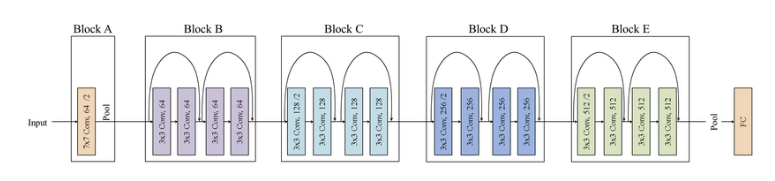

residual connection을 가지고 있는 각 블록을 하나의 residual block으로 보시면 됩니다! 예를 들어, block_b는 2개의 residual block으로 구성되어 있는 것입니다.
block c, d, e의 첫 레이어에 보면 '/2'가 있을 것입니다. 이는 stride=2를 나타내며, 해당 레이어에서만 입력과 출력의 shape 차이가 발생합니다.
<br>block들 간의 batch normalization, activation이 해당 그림에서는 생략되어 있습니다. 피피티의 그림과 함께 보시면 이해에 도움이 될 것입니다!

저희는 구현의 편리함을 위해, 두 개의 residual block을 하나의 클래스로 합쳐서 구현할 것입니다. 그러면 나중에 block a부터 끝까지 쌓아 올릴 때, block_b = ResidualBlock()처럼, 조금 더 간편하게 구현할 수 있겠죠? 이제 시작해 봅시다!

### 문제 3. 아래 class의 빈칸을 채워주세요. 위의 그림과 피피티에서의 그림을 모두 참고하시면 됩니다!

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self,  in_channels, out_channels, strides=1, use_1conv=True):
        super().__init__()
        self.use_1conv = use_1conv

        self.block1 = nn.Sequential(
          ##################################################
          ## TODO: 첫 번째 residual block을 구현해 주세요 ##
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels)
          ##################################################
        )
        self.block2 = nn.Sequential(
          ##################################################
          ## TODO: 두 번째 residual block을 구현해 주세요 ##
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=strides),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels)
          ##################################################
        )
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) ### 1*1 convolution을 구현해 주세요 ###

    def forward(self, x):
      ######################################################################################
      ### TODO: model의 forward를 구현해 주세요. residual connection을 여기에 만들어 주세요 ###
        output1, output2 = None, None

        if self.use_1conv:
          output1 = F.relu(self.block2(x) + self.conv(x))
          output2 = F.relu(self.block1(output1) + output1)
        else:
          output1 = F.relu(self.block1(x) + x)
          output2 = F.relu(self.block1(output1) + output1)

      ######################################################################################
        return output2

class ResNet(nn.Module):
    def __init__(self, output_class, use_1conv=True):
        super().__init__()
          #################################
          ## TODO block들을 구현해 주세요 ##
          #################################

        self.block_a = nn.Sequential(
            #############################
            ########## TODO:#############
            #############################
            nn.Conv2d(3, 64, kernel_size=7, stride=2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(3)
        )

        self.block_b = ResidualBlock(in_channels=64, out_channels=64, use_1conv=False)
        self.block_c = ResidualBlock(in_channels=64, out_channels=128, strides=2, use_1conv=True)
        self.block_d = ResidualBlock(in_channels=128, out_channels=256, strides=2, use_1conv=True)
        self.block_e = ResidualBlock(in_channels=256, out_channels=512, strides=2, use_1conv=True)

        self.final_layer = nn.Sequential(
            #############################
            ########## TODO #############
            #############################
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(1, 3),
            nn.Linear(512, output_class)
        )

    def forward(self, x):
      ###############################################
      ## TODO: Model의 forward pass를 구현해 주세요##
      ###############################################
        output_a = self.block_a(x)
        output_b = self.block_b(output_a)
        output_c = self.block_c(output_b)
        output_d = self.block_d(output_c)
        output_e = self.block_e(output_d)
        output = self.final_layer(output_e)
        return output

## 1.7 모델 학습
이제 모델을 학습시켜 봅시다! 먼저 모델 학습 전에, loss와 optimizer, learning rate, learning rate scheduler, 그리고 epoch 수를 지정해 줍시다.

learning rate scheduler는 학습률을 학습이 진행됨에 따라 조정하는 역할을 합니다. 학습이 진행될수록, minima에 도달할 확률이 높아지기 때문에, minima를 찾기 위해서 학습률을 작게 조정하는 것은 도움이 되겠죠?

loss는 Cross Entropy Loss를 사용해 주시되, optimizer와 epoch 수, 학습률 및 스케쥴러는 자유롭게 바꾸셔도 괜찮습니다.
더 많은 정보는 다음 링크를 참조해 주세요:
<br>
https://pytorch.org/docs/stable/optim.html
<br>
https://sanghyu.tistory.com/113
<br>
https://github.com/kuangliu/pytorch-cifar


In [ ]:
model = ResNet(output_class=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95 ** epoch, last_epoch=-1)
epoch = 50

### 문제 4. Training 함수를 구현해 주세요

In [ ]:
def train_model(train_dataset, val_dataset, model, criterion, optimizer, scheduler, num_epochs=10):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

          # Wrap the training loop with tqdm for a progress bar
        for i, data in tqdm(enumerate(train_dataset, 0), total=len(train_dataset), desc=f"Epoch {epoch+1}"):
              #########################################
              ## TODO: training phase를 구현해 주세요##
              #########################################
            x, y = data['image'], data['label']
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predictions = outputs.max(1)
            correct += (predictions == y).sum().item()
            total += predictions.size(0)


        train_loss = running_loss / len(train_dataset)
        train_acc = 100 * correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        print(train_loss_history, train_acc_history)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for data in val_dataset:
              ###########################################
              ## TODO: validation phase를 구현해 주세요##
              ###########################################
                x, y = data['image'], data['label']
                x = x.to(device)
                y = y.to(device)

                outputs = model(x)
                loss = criterion(outputs, y)

                val_loss += loss.item()
                _, predictions = outputs.max(1)
                val_correct += (predictions == y).sum().item()
                val_total += predictions.size(0)

        val_loss /= len(val_dataset)
        val_acc = 100 * val_correct / val_total
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        scheduler.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

def test_model(test_dataset, model, criterion, optimizer):
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in test_dataset:
            inputs, labels = data['image'].to(device), data['label'].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_acc = 100 * test_correct / test_total
    print(f'Test Accurcy: {test_acc:.2f}%')

### 학습을 진행해 봅시다!

In [ ]:
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(train_dataset=train_loader, val_dataset=val_loader, model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler, num_epochs=epoch)
test_model(test_dataset=test_loader, model=model, criterion=criterion, optimizer=optimizer)

Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]<ipython-input-9-34ae77e7c6b2>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image)
Epoch 1: 100%|██████████| 625/625 [00:35<00:00, 17.52it/s]


[1.72867671585083] [36.68]
Epoch [1/50], Train Loss: 1.7287, Train Acc: 36.68%
Epoch [1/50], Val Loss: 1.5216, Val Acc: 44.48%


Epoch 2: 100%|██████████| 625/625 [00:32<00:00, 18.98it/s]


[1.72867671585083, 1.4674355169296265] [36.68, 46.9625]
Epoch [2/50], Train Loss: 1.4674, Train Acc: 46.96%
Epoch [2/50], Val Loss: 1.3828, Val Acc: 50.06%


Epoch 3: 100%|██████████| 625/625 [00:32<00:00, 19.24it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333] [36.68, 46.9625, 51.76]
Epoch [3/50], Train Loss: 1.3485, Train Acc: 51.76%
Epoch [3/50], Val Loss: 1.2522, Val Acc: 55.07%


Epoch 4: 100%|██████████| 625/625 [00:31<00:00, 19.97it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808] [36.68, 46.9625, 51.76, 54.635]
Epoch [4/50], Train Loss: 1.2687, Train Acc: 54.63%
Epoch [4/50], Val Loss: 1.1889, Val Acc: 57.28%


Epoch 5: 100%|██████████| 625/625 [00:32<00:00, 19.44it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646] [36.68, 46.9625, 51.76, 54.635, 56.6425]
Epoch [5/50], Train Loss: 1.2110, Train Acc: 56.64%
Epoch [5/50], Val Loss: 1.1364, Val Acc: 59.29%


Epoch 6: 100%|██████████| 625/625 [00:32<00:00, 19.11it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525]
Epoch [6/50], Train Loss: 1.1592, Train Acc: 58.65%
Epoch [6/50], Val Loss: 1.0844, Val Acc: 61.26%


Epoch 7: 100%|██████████| 625/625 [00:32<00:00, 19.43it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425]
Epoch [7/50], Train Loss: 1.1170, Train Acc: 60.14%
Epoch [7/50], Val Loss: 1.0776, Val Acc: 61.19%


Epoch 8: 100%|██████████| 625/625 [00:32<00:00, 19.00it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495]
Epoch [8/50], Train Loss: 1.0848, Train Acc: 61.49%
Epoch [8/50], Val Loss: 1.0191, Val Acc: 63.68%


Epoch 9: 100%|██████████| 625/625 [00:33<00:00, 18.74it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43]
Epoch [9/50], Train Loss: 1.0563, Train Acc: 62.43%
Epoch [9/50], Val Loss: 0.9869, Val Acc: 64.81%


Epoch 10: 100%|██████████| 625/625 [00:32<00:00, 19.28it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125]
Epoch [10/50], Train Loss: 1.0283, Train Acc: 63.51%
Epoch [10/50], Val Loss: 0.9849, Val Acc: 64.78%


Epoch 11: 100%|██████████| 625/625 [00:31<00:00, 19.68it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21]
Epoch [11/50], Train Loss: 1.0024, Train Acc: 64.21%
Epoch [11/50], Val Loss: 0.9450, Val Acc: 66.43%


Epoch 12: 100%|██████████| 625/625 [00:32<00:00, 19.53it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67]
Epoch [12/50], Train Loss: 0.9707, Train Acc: 65.67%
Epoch [12/50], Val Loss: 0.9130, Val Acc: 67.69%


Epoch 13: 100%|██████████| 625/625 [00:32<00:00, 19.28it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025]
Epoch [13/50], Train Loss: 0.9515, Train Acc: 66.40%
Epoch [13/50], Val Loss: 0.9016, Val Acc: 67.75%


Epoch 14: 100%|██████████| 625/625 [00:33<00:00, 18.86it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9]
Epoch [14/50], Train Loss: 0.9321, Train Acc: 66.90%
Epoch [14/50], Val Loss: 0.8834, Val Acc: 68.48%


Epoch 15: 100%|██████████| 625/625 [00:32<00:00, 19.34it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775]
Epoch [15/50], Train Loss: 0.9072, Train Acc: 67.78%
Epoch [15/50], Val Loss: 0.8670, Val Acc: 69.31%


Epoch 16: 100%|██████████| 625/625 [00:31<00:00, 19.77it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32]
Epoch [16/50], Train Loss: 0.8871, Train Acc: 68.32%
Epoch [16/50], Val Loss: 0.8336, Val Acc: 70.38%


Epoch 17: 100%|██████████| 625/625 [00:31<00:00, 19.60it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225]
Epoch [17/50], Train Loss: 0.8739, Train Acc: 68.92%
Epoch [17/50], Val Loss: 0.8332, Val Acc: 70.56%


Epoch 18: 100%|██████████| 625/625 [00:32<00:00, 19.34it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675]
Epoch [18/50], Train Loss: 0.8612, Train Acc: 69.47%
Epoch [18/50], Val Loss: 0.8082, Val Acc: 71.08%


Epoch 19: 100%|██████████| 625/625 [00:32<00:00, 19.19it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025]
Epoch [19/50], Train Loss: 0.8427, Train Acc: 70.00%
Epoch [19/50], Val Loss: 0.7897, Val Acc: 71.92%


Epoch 20: 100%|██████████| 625/625 [00:33<00:00, 18.79it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625]
Epoch [20/50], Train Loss: 0.8340, Train Acc: 70.26%
Epoch [20/50], Val Loss: 0.7821, Val Acc: 72.25%


Epoch 21: 100%|██████████| 625/625 [00:31<00:00, 19.60it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995]
Epoch [21/50], Train Loss: 0.8172, Train Acc: 71.00%
Epoch [21/50], Val Loss: 0.7657, Val Acc: 72.76%


Epoch 22: 100%|██████████| 625/625 [00:31<00:00, 19.61it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 71.5475]
Epoch [22/50], Train Loss: 0.8079, Train Acc: 71.55%
Epoch [22/50], Val Loss: 0.7649, Val Acc: 72.61%


Epoch 23: 100%|██████████| 625/625 [00:32<00:00, 19.30it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 71.5475, 71.525]
Epoch [23/50], Train Loss: 0.7972, Train Acc: 71.53%
Epoch [23/50], Val Loss: 0.7472, Val Acc: 73.35%


Epoch 24: 100%|██████████| 625/625 [00:33<00:00, 18.84it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 71.5475, 71.525, 71.88]
Epoch [24/50], Train Loss: 0.7879, Train Acc: 71.88%
Epoch [24/50], Val Loss: 0.7368, Val Acc: 73.57%


Epoch 25: 100%|██████████| 625/625 [00:32<00:00, 19.13it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 71.5475, 71.525, 71.88, 72.4075]
Epoch [25/50], Train Loss: 0.7749, Train Acc: 72.41%
Epoch [25/50], Val Loss: 0.7198, Val Acc: 74.37%


Epoch 26: 100%|██████████| 625/625 [00:32<00:00, 19.49it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 71.5475, 71.525, 71.88, 72.4075, 72.8075]
Epoch [26/50], Train Loss: 0.7663, Train Acc: 72.81%
Epoch [26/50], Val Loss: 0.7111, Val Acc: 74.90%


Epoch 27: 100%|██████████| 625/625 [00:32<00:00, 19.53it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 71.5475, 71.525, 71.88, 72.4075, 72.8075, 72.8925]
Epoch [27/50], Train Loss: 0.7613, Train Acc: 72.89%
Epoch [27/50], Val Loss: 0.7069, Val Acc: 74.92%


Epoch 28: 100%|██████████| 625/625 [00:32<00:00, 19.29it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 71.5475, 71.525, 71.88, 72.4075, 72.8075, 72.8925, 73.4475]
Epoch [28/50], Train Loss: 0.7482, Train Acc: 73.45%
Epoch [28/50], Val Loss: 0.6987, Val Acc: 74.93%


Epoch 29: 100%|██████████| 625/625 [00:32<00:00, 19.31it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 71.5475, 71.525, 71.88, 72.4075, 72.8075, 72.8925, 73.4475, 74.0125]
Epoch [29/50], Train Loss: 0.7329, Train Acc: 74.01%
Epoch [29/50], Val Loss: 0.6901, Val Acc: 75.43%


Epoch 30: 100%|██████████| 625/625 [00:32<00:00, 18.99it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 71.5475, 71.525, 71.88, 72.4075, 72.8075, 72.8925, 73.4475, 74.0125, 73.6475]
Epoch [30/50], Train Loss: 0.7389, Train Acc: 73.65%
Epoch [30/50], Val Loss: 0.6761, Val Acc: 75.97%


Epoch 31: 100%|██████████| 625/625 [00:31<00:00, 19.58it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759, 0.7173551140785217] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 71.5475, 71.525, 71.88, 72.4075, 72.8075, 72.8925, 73.4475, 74.0125, 73.6475, 74.165]
Epoch [31/50], Train Loss: 0.7174, Train Acc: 74.17%
Epoch [31/50], Val Loss: 0.6692, Val Acc: 76.15%


Epoch 32: 100%|██████████| 625/625 [00:31<00:00, 19.85it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759, 0.7173551140785217, 0.7110797533035278] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 71.5475, 71.525, 71.88, 72.4075, 72.8075, 72.8925, 73.4475, 74.0125, 73.6475, 74.165, 74.8625]
Epoch [32/50], Train Loss: 0.7111, Train Acc: 74.86%
Epoch [32/50], Val Loss: 0.6725, Val Acc: 76.10%


Epoch 33: 100%|██████████| 625/625 [00:32<00:00, 19.46it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759, 0.7173551140785217, 0.7110797533035278, 0.7035804068565369] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 71.5475, 71.525, 71.88, 72.4075, 72.8075, 72.8925, 73.4475, 74.0125, 73.6475, 74.165, 74.8625, 75.035]
Epoch [33/50], Train Loss: 0.7036, Train Acc: 75.03%
Epoch [33/50], Val Los

Epoch 34: 100%|██████████| 625/625 [00:33<00:00, 18.86it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759, 0.7173551140785217, 0.7110797533035278, 0.7035804068565369, 0.6990157903671265] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 71.5475, 71.525, 71.88, 72.4075, 72.8075, 72.8925, 73.4475, 74.0125, 73.6475, 74.165, 74.8625, 75.035, 75.21]
Epoch [34/50], Train Loss: 0.6990, Train Acc: 75

Epoch 35: 100%|██████████| 625/625 [00:33<00:00, 18.91it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759, 0.7173551140785217, 0.7110797533035278, 0.7035804068565369, 0.6990157903671265, 0.6968013171672821] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 71.5475, 71.525, 71.88, 72.4075, 72.8075, 72.8925, 73.4475, 74.0125, 73.6475, 74.165, 74.8625, 75.035, 75.21, 75.2725]
Epoch [35/50], Trai

Epoch 36: 100%|██████████| 625/625 [00:32<00:00, 19.43it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759, 0.7173551140785217, 0.7110797533035278, 0.7035804068565369, 0.6990157903671265, 0.6968013171672821, 0.6863048001766204] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 71.5475, 71.525, 71.88, 72.4075, 72.8075, 72.8925, 73.4475, 74.0125, 73.6475, 74.165, 74.8625, 75.035, 75.21, 75.2725,

Epoch 37: 100%|██████████| 625/625 [00:32<00:00, 19.09it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759, 0.7173551140785217, 0.7110797533035278, 0.7035804068565369, 0.6990157903671265, 0.6968013171672821, 0.6863048001766204, 0.6820359870433808] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 71.5475, 71.525, 71.88, 72.4075, 72.8075, 72.8925, 73.4475, 74.0125, 73.6475, 74.165, 74.8625, 75.

Epoch 38: 100%|██████████| 625/625 [00:32<00:00, 19.30it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759, 0.7173551140785217, 0.7110797533035278, 0.7035804068565369, 0.6990157903671265, 0.6968013171672821, 0.6863048001766204, 0.6820359870433808, 0.6714366682052613] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 71.5475, 71.525, 71.88, 72.4075, 72.8075, 72.8925, 73.4475, 74.0125, 73.6475, 

Epoch 39: 100%|██████████| 625/625 [00:32<00:00, 19.16it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759, 0.7173551140785217, 0.7110797533035278, 0.7035804068565369, 0.6990157903671265, 0.6968013171672821, 0.6863048001766204, 0.6820359870433808, 0.6714366682052613, 0.6735640543460846] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 71.5475, 71.525, 71.88, 72.4075, 72.8075, 72.8925, 73.4475

Epoch 40: 100%|██████████| 625/625 [00:32<00:00, 19.26it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759, 0.7173551140785217, 0.7110797533035278, 0.7035804068565369, 0.6990157903671265, 0.6968013171672821, 0.6863048001766204, 0.6820359870433808, 0.6714366682052613, 0.6735640543460846, 0.659752724981308] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 71.5475, 71.525, 71.88, 72.4075, 72.807

Epoch 41: 100%|██████████| 625/625 [00:31<00:00, 19.83it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759, 0.7173551140785217, 0.7110797533035278, 0.7035804068565369, 0.6990157903671265, 0.6968013171672821, 0.6863048001766204, 0.6820359870433808, 0.6714366682052613, 0.6735640543460846, 0.659752724981308, 0.6608444152355194] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 71.5475, 71.525, 71

Epoch 42: 100%|██████████| 625/625 [00:31<00:00, 19.57it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759, 0.7173551140785217, 0.7110797533035278, 0.7035804068565369, 0.6990157903671265, 0.6968013171672821, 0.6863048001766204, 0.6820359870433808, 0.6714366682052613, 0.6735640543460846, 0.659752724981308, 0.6608444152355194, 0.657919497013092] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025, 70.2625, 70.995, 

Epoch 43: 100%|██████████| 625/625 [00:31<00:00, 19.59it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759, 0.7173551140785217, 0.7110797533035278, 0.7035804068565369, 0.6990157903671265, 0.6968013171672821, 0.6863048001766204, 0.6820359870433808, 0.6714366682052613, 0.6735640543460846, 0.659752724981308, 0.6608444152355194, 0.657919497013092, 0.653219061422348] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.9225, 69.4675, 70.0025

Epoch 44: 100%|██████████| 625/625 [00:32<00:00, 19.10it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759, 0.7173551140785217, 0.7110797533035278, 0.7035804068565369, 0.6990157903671265, 0.6968013171672821, 0.6863048001766204, 0.6820359870433808, 0.6714366682052613, 0.6735640543460846, 0.659752724981308, 0.6608444152355194, 0.657919497013092, 0.653219061422348, 0.6456331639766694] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 67.775, 68.32, 68.92

Epoch 45: 100%|██████████| 625/625 [00:32<00:00, 19.08it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759, 0.7173551140785217, 0.7110797533035278, 0.7035804068565369, 0.6990157903671265, 0.6968013171672821, 0.6863048001766204, 0.6820359870433808, 0.6714366682052613, 0.6735640543460846, 0.659752724981308, 0.6608444152355194, 0.657919497013092, 0.653219061422348, 0.6456331639766694, 0.644043910741806] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.67, 66.4025, 66.9, 6

Epoch 46: 100%|██████████| 625/625 [00:31<00:00, 19.80it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759, 0.7173551140785217, 0.7110797533035278, 0.7035804068565369, 0.6990157903671265, 0.6968013171672821, 0.6863048001766204, 0.6820359870433808, 0.6714366682052613, 0.6735640543460846, 0.659752724981308, 0.6608444152355194, 0.657919497013092, 0.653219061422348, 0.6456331639766694, 0.644043910741806, 0.639041995048523] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 63.5125, 64.21, 65.6

Epoch 47: 100%|██████████| 625/625 [00:31<00:00, 19.75it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759, 0.7173551140785217, 0.7110797533035278, 0.7035804068565369, 0.6990157903671265, 0.6968013171672821, 0.6863048001766204, 0.6820359870433808, 0.6714366682052613, 0.6735640543460846, 0.659752724981308, 0.6608444152355194, 0.657919497013092, 0.653219061422348, 0.6456331639766694, 0.644043910741806, 0.639041995048523, 0.6346781165122986] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.1425, 61.495, 62.43, 

Epoch 48: 100%|██████████| 625/625 [00:31<00:00, 19.57it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759, 0.7173551140785217, 0.7110797533035278, 0.7035804068565369, 0.6990157903671265, 0.6968013171672821, 0.6863048001766204, 0.6820359870433808, 0.6714366682052613, 0.6735640543460846, 0.659752724981308, 0.6608444152355194, 0.657919497013092, 0.653219061422348, 0.6456331639766694, 0.644043910741806, 0.639041995048523, 0.6346781165122986, 0.63447199010849] [36.68, 46.9625, 51.76, 54.635, 56.6425, 58.6525, 60.142

Epoch 49: 100%|██████████| 625/625 [00:32<00:00, 19.01it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759, 0.7173551140785217, 0.7110797533035278, 0.7035804068565369, 0.6990157903671265, 0.6968013171672821, 0.6863048001766204, 0.6820359870433808, 0.6714366682052613, 0.6735640543460846, 0.659752724981308, 0.6608444152355194, 0.657919497013092, 0.653219061422348, 0.6456331639766694, 0.644043910741806, 0.639041995048523, 0.6346781165122986, 0.63447199010849, 0.6244641563415527] [36.68, 46.9625, 51.76, 54.635, 56.6

Epoch 50: 100%|██████████| 625/625 [00:32<00:00, 19.02it/s]


[1.72867671585083, 1.4674355169296265, 1.3485422248840333, 1.2687498106002808, 1.2109707070350646, 1.159246644592285, 1.1169785046577454, 1.0848384187698363, 1.0563126912117005, 1.0283089287757874, 1.002411360168457, 0.9707386081695557, 0.9515021567344666, 0.9321068671226501, 0.9072206853866577, 0.887058510684967, 0.8739021484375, 0.8611943185806274, 0.8427321278572083, 0.833970079612732, 0.817198769569397, 0.8079097954750061, 0.7972245516777039, 0.7879001927375794, 0.7748519847869874, 0.7662713120937348, 0.7613405833244323, 0.7482473374843598, 0.7328684247970582, 0.7389291525840759, 0.7173551140785217, 0.7110797533035278, 0.7035804068565369, 0.6990157903671265, 0.6968013171672821, 0.6863048001766204, 0.6820359870433808, 0.6714366682052613, 0.6735640543460846, 0.659752724981308, 0.6608444152355194, 0.657919497013092, 0.653219061422348, 0.6456331639766694, 0.644043910741806, 0.639041995048523, 0.6346781165122986, 0.63447199010849, 0.6244641563415527, 0.6235089247226715] [36.68, 46.9625,

### 학습 정확도, loss 그래프도 그려봅시다.

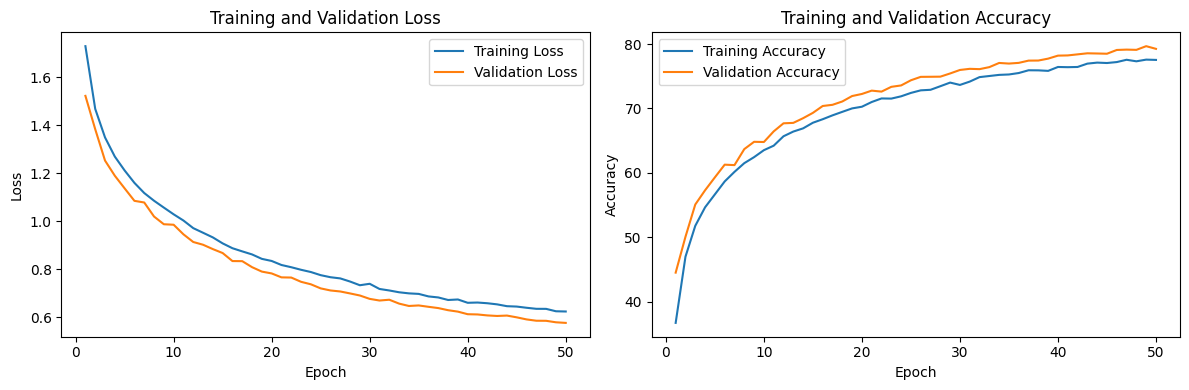

In [ ]:
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### 실행 ###
plot_loss_accuracy(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

#### 문제 5. ResNet의 CIFAR-10에 대한 정확도는 약 91프로입니다. 그렇다면, 우리가 학습시킨 모델은 training data에 대해 underfitting된 것일까요? 아님 overfitting된 것일까요? 만일 underfitting되었다면, 추가적으로 모델을 학습시킬 수 있는 방법은 무엇이 있을까요? 학습률, optimizer, epoch 수, batch size, train-validation set split 비율 등등.. 학습과 연관이 있는 변수들과 관련지어서 설명해 주세요.  

답: 모델을 학습시킨 결과, test accuracy가 73% 정도였기에 underfitting 되었다고 볼 수 있다. 정확도를 높이기 위해서 우선 하이퍼 파라미터를 조정해볼 수 있다. 학습률이나 에폭 수 등을 다양하게 바꾸면서 성능을 더 높일 수 있을 것이다. 또한 다른 종류의 optimizer와 scheduler를 사용해볼 수 있다. 현재는 Adam optimizer를 사용하고 lambda LR scheduler를 사용하여 0.95^epoch 이라는 수식을 통해 학습률을 조정하였는데, 이를 달리하여 모델의 성능을 높일 수 있다.

# Part 2 네이버 영화리뷰 전처리 및 LSTM 구현

이번 부분에서는 LSTM을 활용하여, 네이버 영화리뷰의 sentimental analysis를 진행해볼 것입니다. <br>




###2.1 패키지 설치
우선 필요한 패키지들을 pip을 통해 설치해 봅시다.

In [5]:
!pip install sentencepiece
!pip install wget

### 2.2 import 및 device 설정

필요한 라이브러리를 import하고, device를 GPU로 바꿔줍니다.

다만, 코드를 구현하는 과정에서는 **CPU 사용**을 권장드립니다.

GPU가 가장 많이 필요한 단계는 학습하는 과정인데 구현하는 시간동안 colab의 GPU를 다 써버리면 막상 학습할 때 필요한 GPU 자원을 쓸 수 없게 됩니다. 따라서 코드를 모두 구현하고 train 코드가 잘 돌아가는지 확인한 뒤에 colab 상단 런타임 메뉴에서 런타임 유형을 GPU로 바꾼 뒤에 실행하면 됩니다.

In [6]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import json
import pandas as pd
from IPython.display import display
from tqdm import tqdm, tqdm_notebook, trange
import sentencepiece as spm
import wget

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device: ', device)

using device:  cuda


### 2-3. Dataset
이번 과제에서 사용할 데이터셋입니다. 아래 링크에서 다운 받은 뒤 위에서 설정한 data를 저장할 폴더에 저장해주세요!

colab에서 그 데이터를 직접 확인하는 코드는 작성해두지 않았습니다. 다만, 아래 사진을 첨부해드렸습니다. 데이터는 id, document, label로 구성되어 있고 id는 식별자, document는 리뷰 데이터, label은 긍정(1), 부정(0)을 의미합니다. 좀 더 자세하게 데이터가 어떻게 생겼는지 알고 싶으신 분들은 txt 파일을 열어보시면 확인할 수 있습니다.

보통 csv나 xslx 형태의 텍스트 데이터들은 데이터프레임으로 가공 후 학습하거나 추론에 활용합니다. 데이터프레임으로 데이터를 불러왔다면
ex) dataframe['id'], dataframe['document'] 와 같이 원하는 column의 데이터만을 확인할 수도 있습니다.

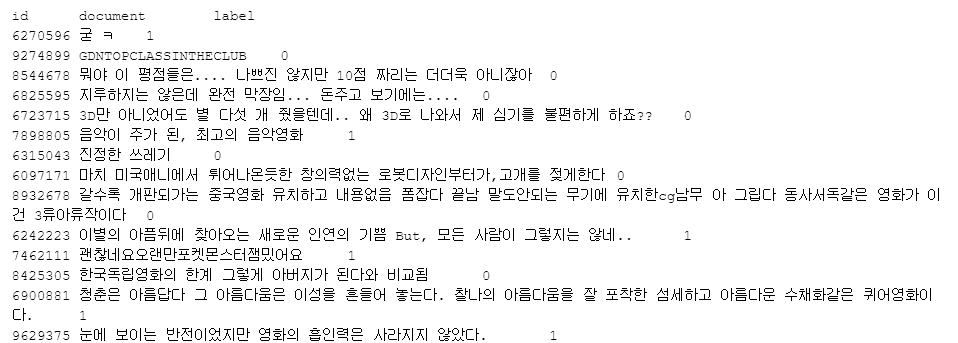


https://drive.google.com/file/d/1Qg_Kd0iyMQ5zYOYGTosVxY00qS6y89lX/view?usp=drive_link

수정: https://drive.google.com/drive/folders/15XGr-L-W6DSoR5TbniPMJASPsA0IDTiN

### 2-4. 폴더의 목록을 확인
Google Drive mount가 잘 되었는지 확인하기 위해 data_dir 목록을 확인 합니다.

In [7]:
for f in os.listdir(data_dir):
  print(f)

kowiki.model
kowiki.vocab
ratings_train.txt
ratings_test.txt
ratings_train.json
ratings_test.json
save_gpt_pretrain.pth
save_bert_pretrain.pth
kowiki_t5.vocab
kowiki_t5.model
save_t5_pretrain.pth
ratings_train_t5.json
ratings_test_t5.json


### 2-5. Vocab 및 입력
미리 만들어 놓은 vocab을 로딩하고, 로딩된 vocab을 이용해 input을 만듭니다.

In [8]:
# vocab loading
vocab_file = f"{data_dir}/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

보통 영어를 NLP task를 처리할 때는 단어 기준으로 나누어도 크게 문제가 없지만 한국어는 한 단어가 보다 복잡하게 이루어져 있습니다. vocab을 사용해서 하나의 리뷰 문장을 나누어준 예시입니다.

아래는 한국어 NLP를 어떤식으로 처리하는지에 대해 간단하게 보여주기 위해 추가한 코드입니다.

In [9]:
line = '뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아'
pieces = vocab.encode_as_pieces(line)
ids = vocab.encode_as_ids(line)
print(line)
print(pieces)
print(ids)

뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
['▁', '뭐', '야', '▁이', '▁평', '점', '들은', '..', '..', '▁나', '쁘', '진', '▁않', '지만', '▁10', '점', '▁', '짜', '리는', '▁더', '더', '욱', '▁아니', '잖', '아']
[3587, 5593, 3766, 8, 229, 3807, 162, 1920, 1920, 57, 5043, 3704, 101, 98, 129, 3807, 3587, 4351, 367, 228, 3840, 4267, 410, 5941, 3621]


## 2-6. 영화 분류 데이터셋
이제 본격적으로 구현을 시작하기 전에 다운했던 데이터셋을 학습 과정에서 사용할 수 있도록 로드할 차례입니다.

먼저 아래 'MovieDataSet' 클래스를 봅시다. 여러분이 따로 구현해야할 코드는 없지만 일반적으로 딥러닝에서 DataSet 클래스를 선언할 때 다음과 같이 \_\_len__과
 \_\_getitem__ 을 같이 선언해주게 됩니다. 이 형태에 대해서 한 번 확인해주고 넘어가면 좋을 것 같아요!

In [10]:
""" 영화 분류 데이터셋 """
class MovieDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.labels = []
        self.sentences = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            for i, line in enumerate(tqdm(f, total=line_cnt, desc=f"Loading {infile}", unit=" lines")):
                data = json.loads(line)
                self.labels.append(data["label"])
                self.sentences.append([vocab.piece_to_id(p) for p in data["doc"]])

    def __len__(self):
        assert len(self.labels) == len(self.sentences)
        return len(self.labels)

    def __getitem__(self, item):
        return (torch.tensor(self.labels[item]),
                torch.tensor(self.sentences[item]))

아래 'collate_fn' 함수는 하나의 batch 안에서 문장의 길이가 다 다른 경우에 batch 안에서 가장 긴 길이에 맞춰서 나머지 input을 padding 해주는 역할을 합니다.

In [11]:
def movie_collate_fn(inputs):
    labels, enc_inputs = list(zip(*inputs))

    enc_inputs = torch.nn.utils.rnn.pad_sequence(enc_inputs, batch_first=True, padding_value=0)

    batch = [
        torch.stack(labels, dim=0),
        enc_inputs,
    ]
    return batch

이제 DataLoader를 통해 데이터를 불러올 차례입니다.

In [12]:
""" 데이터 로더 """
batch_size = 128
train_dataset = MovieDataSet(vocab, f"{data_dir}/ratings_train.json")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=movie_collate_fn)
test_dataset = MovieDataSet(vocab, f"{data_dir}/ratings_test.json")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=movie_collate_fn)

Loading /content/drive/MyDrive/D2D/2/ratings_train.json: 100%|██████████| 149995/149995 [00:11<00:00, 12914.79 lines/s]
Loading /content/drive/MyDrive/D2D/2/ratings_test.json: 100%|██████████| 49997/49997 [00:04<00:00, 10418.92 lines/s]


In [13]:
# Dataset class에서 __len__을 구현하면 dataset의 크기를 확인할 수 있습니다.
print(len(train_dataset))
# Dataset class에서 __getitem__을 구현하면 dataset을 index를 통해 접근할 수 있습니다.
print(train_dataset[0])

149995
(tensor(0), tensor([  26,  228, 4365, 1920,  132, 4351, 3587, 4351, 3922, 3628, 3857, 3760,
         266, 3678, 3614]))


## LSTM
LSTM(Long Short-Term Memory)은 RNN의 한 종류로, RNN의 장기 의존성 문제를 해결하기 위해 고안되었습니다. LSTM은 셀 상태(cell state)라는 개념을 도입해 정보를 장기적으로 기억하고 전달하는 능력을 갖추고 있습니다.


### 2-7. LSTM Cell
LSTM의 핵심은 LSTM 셀입니다. LSTM 셀은 입력 게이트(input gate), 망각 게이트(forget gate), 출력 게이트(output gate)라는 세 가지 게이트와 셀 상태를 이용해 정보를 저장, 삭제, 출력하는 역할을 합니다. 각 게이트는 시그모이드 함수를 통과해 0에서 1 사이의 값을 갖게 되며, 이는 얼마나 많은 정보를 통과시킬지를 결정하는 '비율'을 의미합니다.

이 LSTMCell 클래스에서는 LSTM 셀의 동작을 구현하고 있습니다. 이 클래스는 PyTorch의 nn.Module 클래스를 상속받아 구현되었으며, LSTM 셀의 입력과 히든 상태를 받아 다음 시점의 히든 상태와 셀 상태를 반환하는 forward 메서드를 정의하고 있습니다.

![](https://miro.medium.com/v2/resize:fit:1400/1*ahafyNt0Ph_J6Ed9_2hvdg.png)

### 문제 6. LSTMCell을 구현해 주세요

In [14]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.xh = nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.hh = nn.Linear(hidden_size, hidden_size * 4, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        ################################################################################
        # TODO:                                                                        #
        # complete code for LSTMCell                                                   #
        ################################################################################
        # Inputs:
        #       input: of shape (batch_size, input_size)
        #       hx: of shape (batch_size, hidden_size)
        # Outputs:
        #       hy: of shape (batch_size, hidden_size)
        #       cy: of shape (batch_size, hidden_size)

        if hx is None:
            # hx = torch.zeros_like(input)
            # hx = (hx, hx)
            hx = torch.zeros(1, self.hidden_size).float().cuda()
            cx = torch.zeros(1, self.hidden_size).float().cuda()

        hx, cx = hx

        gates = self.xh(input) + self.hh(hx)

        # TODO: gates를 4개로 나눠서 i_t, f_t, g_t, o_t를 얻는 과정을 작성해주세요.

        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)

        i_t = F.sigmoid(input_gate)
        f_t = F.sigmoid(forget_gate)
        g_t = F.tanh(cell_gate)
        o_t = F.sigmoid(output_gate)

        cy = cx * f_t + i_t * g_t

        hy = o_t * F.tanh(cy)


        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        return (hy, cy)

### 2-8. LSTM 구현
전체 LSTM 네트워크는 이 LSTM 셀을 이용해 구현됩니다. LSTM 네트워크는 시퀀스의 각 요소를 LSTM 셀에 입력하고, 셀의 출력을 다음 시점의 셀에 전달하는 방식으로 동작합니다. 이렇게 각 시점에서의 LSTM 셀의 출력을 모아 최종 출력을 만들게 됩니다.
![](https://miro.medium.com/v2/resize:fit:1400/0*IHPgKDctINevwboV.png)

### 문제 7. LSTM class를 완성해 주세요

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = LSTMCell(input_size, hidden_size)
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hx=None):
        batch_size = x.size(0)
        seq_len = x.size(1)

        if hx is None:
            # hx = (torch.zeros_like(x[:, 0]), torch.zeros_like(x[:, 0]))
            h = torch.zeros(1, self.hidden_size).float().cuda()
            c = torch.zeros(1, self.hidden_size).float().cuda()
        else:
          h, c = hx
        output = []

        ################################################################################
        # TODO:                                                                        #
        # Complete Code for LSTM                                                       #
        ################################################################################
        for i in range(seq_len):
            # TODO: 입력 x를 embedding 하세요.
            embed = self.embedding(x[:, i])
            # TODO: lstm_cell에 embed와 (h, c)를 입력으로 넣어서 h와 c를 update하세요.
            h, c = self.lstm_cell.forward(embed, (h, c))
            # TODO: update된 h를 output에 추가하세요.
            output.append(h)

        # TODO: output을 적절한 형태로 변환하세요.
        # 여기서는 각 시간 스텝에 대한 hidden state를 담고 있는 output 리스트를
        # 하나의 tensor로 결합합니다. 이 tensor의 shape는 (batch_size, seq_len, hidden_size)가 됩니다.
        # 이를 위해 torch.stack 함수를 사용하며, dim=1로 설정하여 시간 스텝에 대해 stack하게 됩니다.
        torch.stack(output, dim=1).reshape(batch_size, seq_len, self.hidden_size)

        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        output = self.fc(output)
        return output, (h, c)

### 2-9. Naver 영화 리뷰 감성분석 모델 (w/ LSTM)

이제는 구현한 LSTM을 바탕으로 Naver 리뷰의 감성을 분석해볼 차례입니다.  해당 리뷰가 긍정(1)인지 부정(0)인지를 분류하는 Classification 모델입니다.

In [16]:
class MovieClassification(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size, dropout):
        super(MovieClassification, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = LSTMCell(input_size, hidden_size)
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, hx=None):
        batch_size = x.size(0)
        seq_len = x.size(1)

        # if hx is None:
            # hx = (torch.zeros_like(x[:, 0]), torch.zeros_like(x[:, 0])) # WTFWTF
            # h, c = hx

        h = torch.zeros(1, self.hidden_size).float().cuda()
        c = torch.zeros(1, self.hidden_size).float().cuda()

        h = h.to(device) # WTF
        c = c.to(device) # WTF

        for i in range(seq_len):
            embed = self.embedding(x[:, i])
            h, c = self.lstm_cell(embed, (h, c))

        logits = self.classifier(h).flatten()
        return logits


### 2-10. 네이버 영화 리뷰 감성분석 모델 데이터 학습(w/ LSTM)

아래는 train 및 test 코드입니다. test 부분의 빈칸은 train 부분과 같은 부분이므로 train 코드를 구현해주신 뒤에 참고하셔서 적어주시면 되겠습니다.

### 문제 8. train_epoch 함수를 완성해 주세요

In [17]:
def train_epoch(epoch, model, criterion, optimizer, train_loader, clip):
    losses = []
    model.train()
    with tqdm_notebook(total=len(train_loader), desc=f"Train {epoch}") as pbar:
        for i, batch in enumerate(train_loader):
            labels, sentences = map(lambda x: x.to(device), batch)

            labels = labels.float()

            ################################################################################
            # TODO:                                                                        #
            # Complete Train Code                                                          #
            ################################################################################

            # TODO: 옵티마이저의 그래디언트를 초기화해 주세요.
            optimizer.zero_grad()

            # TODO: 모델에 입력 데이터를 전달하여 출력을 얻습니다.
            logits = model(sentences)

            # TODO: 손실 함수를 사용하여 loss을 계산합니다.
            loss = criterion(logits, labels)

            loss_val = loss.item()
            losses.append(loss_val)

            # TODO: 역전파를 수행하여 그래디언트를 계산합니다.
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            # Gradient clipping을 해주는 코드입니다.

            # TODO: 옵티마이저를 사용하여 모델 파라미터를 업데이트합니다.
            optimizer.step()
            ################################################################################
            #                                 END OF YOUR CODE                             #
            ################################################################################


            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)


### 문제 9. validation 함수 (eval_epoch)를 완성해 주세요.

In [18]:
def get_binary_metrics(y_pred, y):
    # find number of TP, TN, FP, FN
    # 평가 metric으로 가장 흔하게 사용되는 F1 Score입니다. 자세한 내용은 https://en.wikipedia.org/wiki/F-score 을 참고해주세요.
    TP=sum(((y_pred == 1)&(y==1)).type(torch.int32))
    FP=sum(((y_pred == 1)&(y==0)).type(torch.int32))
    TN=sum(((y_pred == 0)&(y==0)).type(torch.int32))
    FN=sum(((y_pred == 0)&(y==1)).type(torch.int32))
    accy = (TP+TN)/(TP+FP+TN+FN)

    recall = TP/(TP+FN) if TP+FN!=0 else 0
    prec = TP/(TP+FP) if TP+FP!=0 else 0
    f1 = 2*recall*prec/(recall+prec) if recall+prec !=0 else 0

    return accy, recall, prec, f1

def eval_epoch(model, data_loader, criterion):
    model.eval()
    epoch_loss = 0
    epoch_accy = 0
    epoch_recall = 0
    epoch_prec = 0
    epoch_f1 = 0
    with tqdm_notebook(total=len(data_loader), desc=f"Valid") as pbar:
        for i, batch in enumerate(data_loader):
            labels, sentences = map(lambda x: x.to(device), batch)

            labels = labels.float()
            ################################################################################
            # TODO:                                                                        #
            # Complete Evaluation Code                                                     #
            ################################################################################
            # TODO: 모델에 입력 데이터를 전달하여 출력을 얻습니다.
            logits = model(sentences)

            # TODO: 손실 함수를 사용하여 loss을 계산합니다.
            loss = criterion(logits, labels)

            ################################################################################
            #                                 END OF YOUR CODE                             #
            ################################################################################
            epoch_loss += loss.item()

            preds = (F.sigmoid(logits) >= 0.5).long()
            accy, recall, prec, f1 = get_binary_metrics(preds, labels.long())
            epoch_accy += accy
            epoch_recall += recall
            epoch_prec += prec
            epoch_f1 += f1

            pbar.update(1)

    epoch_accy /= len(data_loader)
    epoch_recall /= len(data_loader)
    epoch_prec /= len(data_loader)
    epoch_f1 /= len(data_loader)
    print(f'\tAccuracy: {epoch_accy:.3f}')
    print(f'\tRecall: {epoch_recall:.3f}')
    print(f'\tPrecision: {epoch_prec:.3f}')
    print(f'\tF1 Score: {epoch_f1:.3f}')
    return epoch_loss / len(data_loader)


### 문제 10. Hyperparamter Tuning

좋은 모델을 구현하는 것도 중요하지만 모델의 성능은 Hyper Parameter에 따라 크게 달라집니다. 특히, learning rate와 epoch가 가장 크게 영향을 주며 hidden_layer의 차원에 따라서도 성능이 달라질 수 있습니다! 모델을 성공적으로 구현했다면 더 좋은 성능을 가진 모델을 스스로 한 번 찾아보세요!

In [19]:
# Hyperparameter
################################################################################
# TODO:                                                                        #
# Hyperparameter Tuning                                                        #
################################################################################


learning_rate = 1e-3      # 1e-3 ~ 1e-5
n_epoch = 15               # epoch 수가 더 늘어나면 좋을까요? 학습을 많이 하니까?
input_size = 256  # 임베딩 차원
hidden_size = 128  # 히든 상태의 차원
vocab_size = 10000  # 전체 단어장의 크기

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################



# 이 외에도 아래 변수들도 Hyperparmeter에 해당하지만 이 부분은 고정해주세요. 위의 Hyperparameter를 tuning해보면서 결과에 큰 차이가 있는지 확인해봅시다.
CLIP = 1                    # Exploding Gradient가 일어날 때 Gradient를 줄여주기 위해 설정하는 값입니다.
dropout = 0.1               # 이 부분은 자세히 배우지 않은 걸로 알고 있어서 추가하진 않았지만 궁금하신 분들은 dropout 값도 tuning 해 보셔도 좋을 것 같습니다.



# 모델을 설정합니다
model = MovieClassification(input_size=input_size, hidden_size=hidden_size, vocab_size=vocab_size, dropout=dropout)
model.to(device)

# 손실함수와 Optimization 형태를 설정해줍니다.
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 가장 성능이 좋은 모델을 저장하기 위해 valid_loss가 가장 작은 값을 찾아야 합니다. 왜 train_loss가 아니라 valid_loss로 판단하는지 생각해봅시다.
best_valid_loss = float('inf')

### Training Phase
이제 직접 학습을 진행해볼 차례입니다! Hyperparameter에 따라 값이 달라지기는 하겠지만 대략적으로 가장 높은 F1 score가 0.8 이상 나오면 모델이 잘 구현된 것입니다.

**모델의 학습이 실제로 되는지 궁금하신 분들은 아래 train 코드를 실행하기 전에 그 아래 inference부터 해보셔도 좋을 것 같습니다.**

모델이 학습이 하나도 되지 않았을 때 감성 분석을 어떻게 하는지 살펴봅시다.

In [20]:
for epoch in range(n_epoch):
    train_loss = train_epoch(epoch, model, criterion, optimizer, train_loader, CLIP)
    valid_loss = eval_epoch(model, test_loader, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')

<ipython-input-17-d2721a7cd1bc>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=len(train_loader), desc=f"Train {epoch}") as pbar:


Train 0:   0%|          | 0/1172 [00:00<?, ?it/s]

<ipython-input-18-2fb9dbbc0ab8>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=len(data_loader), desc=f"Valid") as pbar:


Valid:   0%|          | 0/391 [00:00<?, ?it/s]

	Accuracy: 0.823
	Recall: 0.780
	Precision: 0.856
	F1 Score: 0.815
Epoch: 01 | Train Loss: 0.553 | Val. Loss: 0.388


Train 1:   0%|          | 0/1172 [00:00<?, ?it/s]

	Accuracy: 0.843
	Recall: 0.811
	Precision: 0.869
	F1 Score: 0.838
Epoch: 02 | Train Loss: 0.354 | Val. Loss: 0.350


Train 2:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

	Accuracy: 0.847
	Recall: 0.810
	Precision: 0.877
	F1 Score: 0.841
Epoch: 03 | Train Loss: 0.297 | Val. Loss: 0.345


Train 3:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

	Accuracy: 0.847
	Recall: 0.870
	Precision: 0.833
	F1 Score: 0.850
Epoch: 04 | Train Loss: 0.253 | Val. Loss: 0.354


Train 4:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

	Accuracy: 0.849
	Recall: 0.843
	Precision: 0.855
	F1 Score: 0.848
Epoch: 05 | Train Loss: 0.212 | Val. Loss: 0.371


Train 5:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

	Accuracy: 0.846
	Recall: 0.848
	Precision: 0.846
	F1 Score: 0.846
Epoch: 06 | Train Loss: 0.173 | Val. Loss: 0.391


Train 6:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

	Accuracy: 0.845
	Recall: 0.845
	Precision: 0.847
	F1 Score: 0.845
Epoch: 07 | Train Loss: 0.143 | Val. Loss: 0.478


Train 7:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

	Accuracy: 0.842
	Recall: 0.844
	Precision: 0.843
	F1 Score: 0.842
Epoch: 08 | Train Loss: 0.121 | Val. Loss: 0.513


Train 8:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

	Accuracy: 0.842
	Recall: 0.850
	Precision: 0.838
	F1 Score: 0.843
Epoch: 09 | Train Loss: 0.104 | Val. Loss: 0.547


Train 9:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

	Accuracy: 0.842
	Recall: 0.816
	Precision: 0.862
	F1 Score: 0.838
Epoch: 10 | Train Loss: 0.094 | Val. Loss: 0.539


Train 10:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

	Accuracy: 0.841
	Recall: 0.840
	Precision: 0.843
	F1 Score: 0.840
Epoch: 11 | Train Loss: 0.086 | Val. Loss: 0.569


Train 11:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

	Accuracy: 0.839
	Recall: 0.853
	Precision: 0.831
	F1 Score: 0.841
Epoch: 12 | Train Loss: 0.078 | Val. Loss: 0.539


Train 12:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

	Accuracy: 0.840
	Recall: 0.826
	Precision: 0.853
	F1 Score: 0.838
Epoch: 13 | Train Loss: 0.074 | Val. Loss: 0.568


Train 13:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

	Accuracy: 0.840
	Recall: 0.852
	Precision: 0.834
	F1 Score: 0.841
Epoch: 14 | Train Loss: 0.069 | Val. Loss: 0.630


Train 14:   0%|          | 0/1172 [00:00<?, ?it/s]

Valid:   0%|          | 0/391 [00:00<?, ?it/s]

	Accuracy: 0.841
	Recall: 0.840
	Precision: 0.844
	F1 Score: 0.841
Epoch: 15 | Train Loss: 0.067 | Val. Loss: 0.610


### 2-11 Model Inference
학습된 모델로 직접 리뷰를 몇개 작성해보고 해당 리뷰의 감성을 분석해봅시다. 여기서는 아주 간단하게 모델이 예측한 값이 0.5 이하(0에 가까우면)일 때 부정, 이상(1에 가까우면)일 때 긍정으로 판단하겠습니다.

당연히 모델 성능에 따라 다 맞추지는 못할 것입니다. 비교적 쉬운 문장으로 테스트 해주시면 좋을 것 같고 이 부분이 과제의 마지막 부분입니다! 본인의 예시를 5가지정도(더 많으면 좋아요) 만들어서 모델이 잘 예측하는지 확인해주세요.

In [21]:
def inference(input) :
  sen = [vocab.piece_to_id(p) for p in input]

  input = torch.Tensor(sen).long()
  input = input.reshape(1, -1).to(device)

  # 학습을 하지 않은 경우 저장된 model.pt가 없기 때문에 아래 코드를 주석처리해주셔야 합니다.
  model.load_state_dict(torch.load('model.pt'))

  output = model(input)
  if output < 0.5:
    sentiment = '부정'
  else:
    sentiment = '긍정'
  return sentiment

In [48]:
# 직접 본인만의 예시를 넣어서 inference 해주세요!
# your_example = ["ADHD가 있거나 지능이 낮은 사람은 긴 러닝타임을 버티기 힘드니 예매 취소를 권장함", " 왜 눈물이 나지걘적으로 놀란 감독 잭품 중 최고", "웨이드 너무 취향저격 존귀탱ㅠㅜ 믿고 보는 픽사 디테일 쩔고 비주얼 미쳤음", "안보는걸 추천합니다 보다 속터져 죽습니다", "밀수 당했다 티켓 표값을"]
your_example = ['이 영화는 올해 최고의 영화라고 볼 수 있다',
                '진짜 보고 눈물 콧물 다 흘렸다 흑흑 너무 감동적',
                '이거 볼 바에 차라리 과제하는 게 낫겠다 ㅋㅋ',
                '아직도 이 영화를 안 봤다면 빨리 보러 가세요',
                '안 본 눈 삽니다...',
                '감독이 예산을 대체 어디에 쓴 건지 의문임;;;',
                '보다가 땀 흘릴 정도로 긴장감 넘치네',
                '이거 보다가 안 자면 진짜 불면증 ㅇㅈ',
                '보지마라 그냥 보지마',
                '리뷰 쓰는 시간도 아깝다 ㅋㅋ',
                '100억 받고 이거 보기 vs 그냥 살기',
                '이거 안 보면 인생 손해 본 거',
                '이거보다 벽이랑 대화하는 게 더 재밌음']

for sentence in your_example:
  output = inference(sentence)
  print(f"리뷰 \"{sentence}\"에 대한 감성은 <{output}>입니다.")

리뷰 "이 영화는 올해 최고의 영화라고 볼 수 있다"에 대한 감성은 <긍정>입니다.
리뷰 "진짜 보고 눈물 콧물 다 흘렸다 흑흑 너무 감동적"에 대한 감성은 <긍정>입니다.
리뷰 "이거 볼 바에 차라리 과제하는 게 낫겠다 ㅋㅋ"에 대한 감성은 <부정>입니다.
리뷰 "아직도 이 영화를 안 봤다면 빨리 보러 가세요"에 대한 감성은 <긍정>입니다.
리뷰 "안 본 눈 삽니다..."에 대한 감성은 <부정>입니다.
리뷰 "감독이 예산을 대체 어디에 쓴 건지 의문임;;;"에 대한 감성은 <부정>입니다.
리뷰 "보다가 땀 흘릴 정도로 긴장감 넘치네"에 대한 감성은 <긍정>입니다.
리뷰 "이거 보다가 안 자면 진짜 불면증 ㅇㅈ"에 대한 감성은 <긍정>입니다.
리뷰 "보지마라 그냥 보지마"에 대한 감성은 <부정>입니다.
리뷰 "리뷰 쓰는 시간도 아깝다 ㅋㅋ"에 대한 감성은 <부정>입니다.
리뷰 "100억 받고 이거 보기 vs 그냥 살기"에 대한 감성은 <부정>입니다.
리뷰 "이거 안 보면 인생 손해 본 거"에 대한 감성은 <긍정>입니다.
리뷰 "이거보다 벽이랑 대화하는 게 더 재밌음"에 대한 감성은 <긍정>입니다.


## 3. Conclusion
지금까지 ResNet과 LSTM 형태를 가장 간단하게 활용할 수 있는 과제를 직접 구현해보았습니다. 두 모델을 구현하고 모델을 학습하고, 그리고 추론까지 해보는 과정을 겪었는데 전반적인 과정에 대해서 간단한 소감을 작성해주세요. 추가적으로, 과제 중간 중간에 생각해볼만한 질문들을 몇가지 남겨두었습니다. 이 부분에 대한 답변은 필수는 아니지만 이런 부분에 대해서 답변해주셔도 좋습니다!

만약 학습했던 모델의 성능이 생각보다 좋지 않았다면, 왜 그럴지, 그렇다면 무엇을 고쳐야할지, 잘 모르겠다면 모델의 한계점 등에 대해서 자유롭게 작성해 주세요.

(모델이 잘 작동하지 못하는 이유에는 정답이 없습니다. 따라서 너무 어렵게 생각하지는 말아주세요! )

**Answer:**
코드를 짜면서, tensor의 사이즈와 dtype을 맞추는 것이 생각보다 까다로웠다. 또한 모델의 하이퍼파라미터를 정해야 할 때 아주 막막했다. 학습하는 데 시간이 꽤 걸리는데, 하이퍼파라미터를 하나하나 바꾸면서 성능을 테스트하려니 시간이 오래 걸렸다. 15에폭으로 학습한 결과, train loss는 초기에 비해 크게 줄어들었는데 validation loss는 오히려 늘어나는 결과를 보였다(오버피팅?).
